# Table of Content

<a name="outline"></a>

## Setup

- [A](#seca) External Imports
- [B](#secb) Internal Imports
- [C](#secd) Configurations and Paths 
- [D](#sece) Patient Interface and Train/Val/Test Partitioning


## Evaluations

- [1](#sec2) Predictive Performance: MIMIC-III (Test Set)
- [2](#sec3) Predictive Performance: MIMIC-IV (Test Set)
- [3](#sec4) Predictive Performance: from MIMIC-IV (Training Set) to MIMIC-III (All)

<a name="seca"></a>

### A External Imports [^](#outline)

In [5]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from IPython.display import display
from upsetplot import from_contents, plot, UpSet, from_indicators
import jax

jax.config.update('jax_platform_name', 'cpu')

<a name="secb"></a>

### B Internal Imports [^](#outline)

In [6]:
# HOME and DATA_STORE are arbitrary, change as appropriate.
HOME = os.environ.get('HOME')
DATA_STORE = f'{HOME}/GP/ehr-data'

sys.path.append("..")


from lib import utils as U
from lib.ehr.dataset import load_dataset

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name="secc"></a>

### C Configurations and Paths [^](#outline)

In [7]:
from lib.ehr import OutcomeExtractor, SurvivalOutcomeExtractor
outcome_extractor = OutcomeExtractor('dx_flatccs_filter_v1')
training_dir = 'mimic_artefacts'
output_dir = 'mimic_analysis_artefacts'

Path(output_dir).mkdir(parents=True, exist_ok=True)

In [8]:
# Assign the folder of the dataset to `DATA_FILE`.
HOME = os.environ.get('HOME')
DATA_DIR = f'{HOME}/GP/ehr-data'
SOURCE_DIR = os.path.abspath("..")

with U.modified_environ(DATA_DIR=DATA_DIR):
    m3_dataset = load_dataset('M3')
    m4_dataset = load_dataset('M4')

                Unrecognised <class 'lib.ehr.coding_scheme.DxICD9'> codes (38)
                to be removed: ['041.49', '282.40', '282.46', '284.11', '284.12', '284.19', '294.20', '294.21', '348.82', '365.70', '425.11', '425.18', '444.09', '512.83', '512.84', '512.89', '516.31', '516.34', '516.36', '518.51', '518.52', '518.53', '573.5', '596.89', '719.70', '747.32', '793.11', '793.19', '795.51', '997.49', '998.01', '998.09', '999.32', '999.33', 'V12.55', 'V13.89', 'V54.82', 'V88.21']
                Unrecognised <class 'lib.ehr.coding_scheme.PrICD9'> codes (7)
                to be removed: ['02.21', '17.55', '17.56', '35.05', '36.01', '36.02', '36.05']
                    Unrecognised <class 'lib.ehr.coding_scheme.DxICD10'> codes (4178)
                    to be removed: ['E10.3213', 'E10.3219', 'E10.3291', 'E10.3292', 'E10.3293', 'E10.3299', 'E10.3312', 'E10.3313', 'E10.3391', 'E10.3393', 'E10.3399', 'E10.3411', 'E10.3413', 'E10.3491', 'E10.3492', 'E10.3511', 'E10.3512', 'E10.3513',

                    Unrecognised <class 'lib.ehr.coding_scheme.DxICD9'> codes (127)
                    to be removed: ['041.49', '173.01', '173.21', '173.22', '173.30', '173.31', '173.32', '173.39', '173.41', '173.42', '173.49', '173.50', '173.51', '173.52', '173.59', '173.60', '173.61', '173.62', '173.69', '173.71', '173.72', '173.79', '173.80', '173.81', '173.82', '173.91', '173.92', '173.99', '282.40', '282.43', '282.44', '282.46', '284.11', '284.12', '284.19', '286.52', '286.59', '294.20', '294.21', '310.81', '310.89', '331.6', '348.82', '358.30', '365.70', '365.71', '365.72', '365.73', '365.74', '379.27', '414.4', '415.13', '425.11', '425.18', '444.09', '488.81', '488.82', '488.89', '508.2', '512.2', '512.81', '512.82', '512.83', '512.84', '512.89', '516.31', '516.32', '516.33', '516.34', '516.36', '516.37', '516.5', '518.51', '518.52', '518.53', '539.01', '539.09', '539.89', '573.5', '596.81', '596.82', '596.83', '596.89', '629.31', '629.32', '631.0', '631.8', '649.81', '704.41'

The following cell configures the location of the models pretrained on MIMIC-III (M3) and MIMIC-IV (M4), with GRAM embeddings (G) and without. Each training experiment produces 100 snapshots of parameters (100 training checkpoints throughout all the training iterations), and this Notebook picks the one that maximizes the average AUC of the visit level (prob. of having higher risks for present codes than the absent codes of the same visit).

To download our own experiment files and proceed with the analysis in this Notebook, without having to run any training, send an email to (`asem.a.abdelaziz@imperial.ac.uk`) to have access to a copy of these files (size: `5.1 GB`). 

In [9]:
relative_auc_config = {
    'pvalue': 0.01, 
    'min_auc': 0.9
}
top_k_list=[1, 2, 3, 5, 7, 10, 15, 20]
percentile_range=20 
n_percentiles=int(100/percentile_range)


import matplotlib.font_manager as font_manager
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.family': 'sans-serif',
                     'font.sans-serif': 'Helvetica',
                     'font.weight':  'normal'})

In [10]:
train_dir = {
    # Location of training experiments on MIMIC-III.
    'M3': f'{training_dir}/m3_train',
    # Location of training experiments on MIMIC-IV.
    'M4': f'{training_dir}/m4_train'
}

<a name="secd"></a>

### D Patient Interface and Train/Val/Test Patitioning [^](#outline)

In [11]:
from lib.ehr.coding_scheme import DxCCS, DxFlatCCS, DxICD9, DxICD10
from lib.ehr import Subject_JAX
from lib.ehr import StaticInfoFlags

%load_ext autoreload
%autoreload 2

code_scheme = {
    'dx': DxCCS(), # other options 
    'outcome': outcome_extractor,
    # Comment above^, and uncomment below, to consider only the first occurrence of codes per subject.
    # 'outcome': FirstOccurrenceOutcomeExtractor('dx_flatccs_filter_v1'),
}


static_info_flags = StaticInfoFlags(gender=True, age=True)

m3_interface = Subject_JAX.from_dataset(m3_dataset, 
                                        code_scheme=code_scheme, 
                                        static_info_flags=static_info_flags,
                                       data_max_size_gb=1)
m4_interface = Subject_JAX.from_dataset(m4_dataset, 
                                        code_scheme=code_scheme, 
                                        static_info_flags=static_info_flags,
                                       data_max_size_gb=1)

m3_splits = m3_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)
m4_splits = m4_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



                            S - M_domain (2497, p=0.14371223021582732):
                            ['001', '002', '003', '003.2', '004']...

                            M_domain - S (0, p=0.0):
                            []...

                            M_domain (14878):
                            ['001.0', '001.1', '001.9', '002.0', '002.1']...

                            S (17375): ['001', '001.0', '001.1', '001.9', '002']...

                            S - M_domain (2497, p=0.14371223021582732):
                            ['001', '002', '003', '003.2', '004']...

                            M_domain - S (0, p=0.0):
                            []...

                            M_domain (14878):
                            ['001.0', '001.1', '001.9', '002.0', '002.1']...

                            S (17375): ['001', '001.0', '001.1', '001.9', '002']...
                            dx_icd10->dx_icd9 Unrecognised t_codes
                            (169):
                    

In [12]:
# pecentile_range=20 will partition the codes into five gruops, where each group contains 
# codes that overall constitutes 20% of the codes in all visits of specified 'subjects' list.
m3_code_freq_partitions = m3_interface.outcome_by_percentiles(percentile_range=20, subjects=m3_splits[0])
m4_code_freq_partitions = m4_interface.outcome_by_percentiles(percentile_range=20, subjects=m4_splits[0])


## Metrics

In [13]:
from lib.metric import (CodeAUC, UntilFirstCodeAUC, AdmissionAUC, CodeGroupTopAlarmAccuracy, LossMetric, MetricsCollection)
# pecentile_range=20 will partition the codes into five gruops, where each group contains 
# codes that overall constitutes 20% of the codes in all visits of specified 'subjects' list.
m3_code_freq_partitions = m3_interface.outcome_by_percentiles(percentile_range=20, subjects=m3_splits[0])
m4_code_freq_partitions = m4_interface.outcome_by_percentiles(percentile_range=20, subjects=m4_splits[0])

# Evaluate for different k values
top_k_list = [3, 5, 10, 15, 20]

m3_metrics = {'code_auc': CodeAUC(m3_interface),
              'code_first_auc': UntilFirstCodeAUC(m3_interface),
              'admission_auc': AdmissionAUC(m3_interface),
              'loss': LossMetric(m3_interface),
              'code_group_acc': CodeGroupTopAlarmAccuracy(m3_interface, top_k_list=top_k_list, code_groups=m3_code_freq_partitions)}

m4_metrics = {'code_auc': CodeAUC(m4_interface),
              'code_first_auc': UntilFirstCodeAUC(m4_interface),
              'admission_auc': AdmissionAUC(m4_interface),
              'loss': LossMetric(m4_interface),
              'code_group_acc': CodeGroupTopAlarmAccuracy(m4_interface, top_k_list=top_k_list, code_groups=m4_code_freq_partitions)}

m3_metric_extractor = {
    'code_auc': m3_metrics['code_auc'].aggregate_extractor({'field': 'auc', 'aggregate': 'mean'}),
    'code_first_auc': m3_metrics['code_first_auc'].aggregate_extractor({'field': 'auc', 'aggregate': 'mean'}),
    'admission_auc': m3_metrics['admission_auc'].aggregate_extractor({'field': 'auc', 'aggregate': 'mean'}),
    'loss': m3_metrics['loss'].value_extractor({'field': 'focal_softmax'}),
}

m4_metric_extractor = {
    'code_auc': m4_metrics['code_auc'].aggregate_extractor({'field': 'auc', 'aggregate': 'mean'}),
    'code_first_auc': m4_metrics['code_first_auc'].aggregate_extractor({'field': 'auc', 'aggregate': 'mean'}),
    'admission_auc': m4_metrics['admission_auc'].aggregate_extractor({'field': 'auc', 'aggregate': 'mean'}),
    'loss': m4_metrics['loss'].value_extractor({'field': 'focal_softmax'}),
}

<a name="sec1"></a>

## 1 Snooping/Selecting Best Models from the Validation Set [^](#outline)

In [31]:
from lib.ml import ICENODE, ICENODE_UNIFORM, GRU, RETAIN, WindowLogReg
from lib.vis import models_from_configs, performance_traces, probe_model_snapshots

model_cls = {
    'ICE-NODE': ICENODE,
    'ICE-NODE_UNIFORM': ICENODE_UNIFORM,
    'GRU': GRU,
    'RETAIN': RETAIN,
    'LogReg': WindowLogReg
}       
m3_models = models_from_configs(train_dir['M3'], model_cls, m3_interface, m3_splits)
m4_models = models_from_configs(train_dir['M4'], model_cls, m4_interface, m4_splits)

In [38]:
print('> Models trained on MIMIC-III')
result = probe_model_snapshots(train_dir=train_dir['M3'], metric_extractor=m3_metric_extractor, 
                               selection_metric='admission_auc_val', models=m3_models)
display(result)

print('> Models trained on MIMIC-IV')
result = probe_model_snapshots(train_dir=train_dir['M4'], metric_extractor=m4_metric_extractor, 
                               selection_metric='admission_auc_val', models=m4_models)
display(result)


> Models trained on MIMIC-III


,model,code_auc_idx,code_auc_val,code_first_auc_idx,code_first_auc_val,admission_auc_idx,admission_auc_val,loss_idx,loss_val
ICE-NODE-Ts30E250Ty3,ICE-NODE-Ts30E250Ty3,25,0.532389,20,0.528593,67,0.846997,33,0.020425
ICE-NODE-Ts7E250Ty3,ICE-NODE-Ts7E250Ty3,52,0.523493,6,0.519612,73,0.852697,45,0.020169
ICE-NODE-Ts30E300Ty3,ICE-NODE-Ts30E300Ty3,22,0.519688,1,0.519770,83,0.861588,49,0.020255
ICE-NODE-Ts7E200Ty0,ICE-NODE-Ts7E200Ty0,3,0.529605,30,0.522825,82,0.843226,28,0.020316
ICE-NODE-Ts30E200Ty0,ICE-NODE-Ts30E200Ty0,5,0.535153,0,0.523681,78,0.835303,45,0.020602
GRU,GRU,20,0.716737,2,0.503724,13,0.916605,8,0.015894
ICE-NODE-Ts7E250Ty0,ICE-NODE-Ts7E250Ty0,52,0.523493,6,0.519612,73,0.852697,45,0.020169
ICE-NODE-Ts7E200Ty3,ICE-NODE-Ts7E200Ty3,3,0.529605,30,0.522825,82,0.843226,28,0.020316
ICE-NODE-Ts30E300Ty0,ICE-NODE-Ts30E300Ty0,22,0.519688,1,0.519770,83,0.861588,49,0.020255
ICE-NODE-Ts7E300Ty3,ICE-NODE-Ts7E300Ty3,46,0.527121,0,0.525565,66,0.862928,46,0.020037


> Models trained on MIMIC-IV


,model


<a name="sec2"></a>

## 2 Predictive Performance on MIMIC-III (Test Set) [^](#outline)

In [33]:
test_res_m3 = {model_key: model(m3_interface, m3_splits[2], dict(eval_only=True))['predictions'] 
               for model_key, model in m3_models.items()}


In [34]:
from lib.metric import DeLongTest

m3_delong_metric = DeLongTest(m3_interface)
# m4_delong_metric = DeLongTest(m4_interface)

m3_auctests = m3_delong_metric.to_df(test_res_m3)
# m4_auctests = m3_delong_metric(test_res_m3)


  3%|███▌                                                                                                                     | 7/241 [00:02<01:38,  2.36it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


  6%|██████▉                                                                                                                 | 14/241 [00:05<01:36,  2.36it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


  9%|██████████▉                                                                                                             | 22/241 [00:09<01:33,  2.35it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 12%|██████████████▉                                                                                                         | 30/241 [00:11<01:06,  3.16it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 16%|███████████████████▍                                                                                                    | 39/241 [00:15<01:13,  2.73it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 19%|██████████████████████▉                                                                                                 | 46/241 [00:18<01:20,  2.43it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 22%|██████████████████████████▉                                                                                             | 54/241 [00:20<01:11,  2.62it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 25%|██████████████████████████████▎                                                                                         | 61/241 [00:23<01:12,  2.48it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 28%|█████████████████████████████████▊                                                                                      | 68/241 [00:26<01:10,  2.46it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 32%|█████████████████████████████████████▊                                                                                  | 76/241 [00:29<00:58,  2.84it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 46%|██████████████████████████████████████████████████████▎                                                                | 110/241 [00:32<00:13,  9.63it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 49%|██████████████████████████████████████████████████████████▎                                                            | 118/241 [00:35<00:37,  3.28it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 52%|██████████████████████████████████████████████████████████████▏                                                        | 126/241 [00:38<00:39,  2.88it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 57%|███████████████████████████████████████████████████████████████████▋                                                   | 137/241 [00:40<00:22,  4.64it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 61%|████████████████████████████████████████████████████████████████████████▌                                              | 147/241 [00:43<00:31,  3.02it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 64%|████████████████████████████████████████████████████████████████████████████▌                                          | 155/241 [00:46<00:33,  2.59it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 69%|██████████████████████████████████████████████████████████████████████████████████▍                                    | 167/241 [00:49<00:14,  5.08it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 73%|██████████████████████████████████████████████████████████████████████████████████████▍                                | 175/241 [00:52<00:23,  2.80it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 77%|███████████████████████████████████████████████████████████████████████████████████████████▎                           | 185/241 [00:55<00:16,  3.43it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▊                        | 192/241 [00:57<00:19,  2.55it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 203/241 [01:01<00:13,  2.90it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 211/241 [01:03<00:10,  2.86it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 218/241 [01:06<00:09,  2.52it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 225/241 [01:09<00:06,  2.48it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 233/241 [01:12<00:02,  2.99it/s]WARNING:absl:Indeterminate test, p-value set to max (1.0)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:14<00:00,  3.22it/s]


In [35]:
m3_auctests.to_csv('auc_tests.csv')

In [36]:
from lib.vis import auc_upset


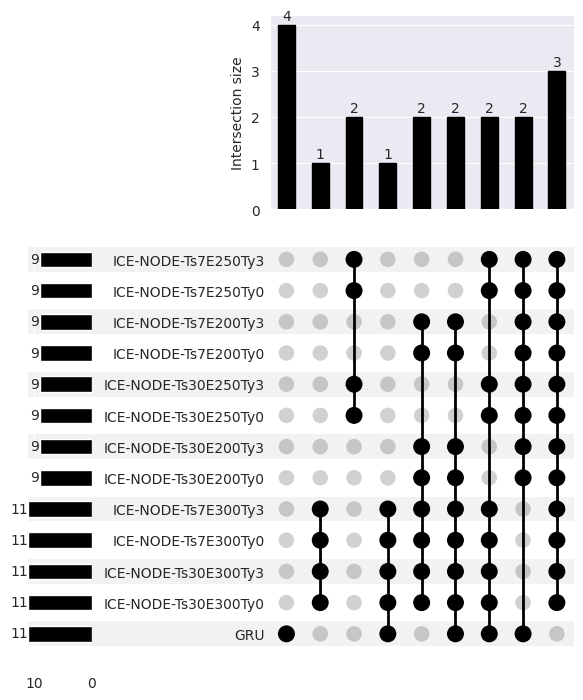

In [37]:
model_keys = list(test_res_m3.keys())
indicator_df, (nodiff_set, diff_set) = auc_upset(m3_delong_metric, m3_auctests, model_keys, 
                                                 p_value=0.05, min_auc=0.7)

upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, 
                                          rc={"font.family": "sans-serif", 
                                          'axes.labelsize': 'medium',
                                          'ytick.labelsize': 'medium'})

with sns.axes_style("darkgrid"): #, upset_ctx():
    upset_format = from_indicators(indicator_df)
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
#     upset_object.style_subsets(absent=['LogReg'], present=('ICE-NODE', 'GRU', 'RETAIN'),
#                                facecolor="red",
#                                edgecolor="red", linewidth=3)
    
    g = upset_object.plot()
        
    current_figure = plt.gcf()
    w, h = 2.5, 3
    wi, hi = current_figure.get_size_inches()
    current_figure.set_size_inches(hi*(w/h), hi)
    current_figure.savefig(f"{output_dir}/m3_upset.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
from lib.metric import CodeGroupTopAlarmAccuracy
from lib.vis import top_k_tables


m3_code_freq_partitions = m3_interface.outcome_by_percentiles(percentile_range=20, subjects=m3_splits[0])

# Evaluate for different k values
top_k_list = [3, 5, 10, 15, 20]

group_acc_metric = CodeGroupTopAlarmAccuracy(m3_interface, top_k_list=top_k_list, 
                                             code_groups=m3_code_freq_partitions)
top_k_results = {k: group_acc_metric.to_df(k, res) for k, res in test_res_m3.items()}
top_k_dfs = top_k_tables(group_acc_metric, top_k_results)

In [81]:
top_k_dfs[3]['raw']

,ACC-P0-k3,ACC-P1-k3,ACC-P2-k3,ACC-P3-k3,ACC-P4-k3
GRU,0.008,0.003,0.000,0.000,0.000
ICE-NODE,0.007,0.010,0.013,0.004,0.016
ICE-NODE_UNIFORM,0.007,0.010,0.013,0.004,0.016
RETAIN,0.008,0.000,0.005,0.000,0.024


In [39]:
# upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
#               'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']

# ax = A.selected_auc_barplot(upset_clfs, competing_tests_df,  horizontal=True)
# ax.legend(fontsize=22, title_fontsize=32,
#           bbox_to_anchor=(-0.02, 1), ncol=2)
# plt.xticks(fontsize=30)
# plt.yticks(fontsize=30)

# current_figure = plt.gcf()
# # w, h = 4, 4
# # wi, hi = current_figure.get_size_inches()
# # current_figure.set_size_inches(hi*(w/h), hi)

# current_figure.savefig(f"{output_dir}/icenode_m3.pdf", bbox_inches='tight')
# plt.show()


[autoreload of lib.ehr.jax_interface failed: Traceback (most recent call last):
  File "/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


<a name="sec3"></a>

## 3 Relative AUC Performance on MIMIC-IV (Test Set) [^](#outline)

In [ ]:
m4_predictors = {clf: cross_predictor(clf, 'M4', 'M4') for clf in clfs}

In [ ]:
test_res_m4 = {clf: C.eval2_(model, m4_test_ids) for clf, model in m4_predictors.items()} 

In [ ]:
auctests_m4 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m4.items()}, fast=True)


85 codes predicted an AUC higher than 0.9 by at least one model.
84 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


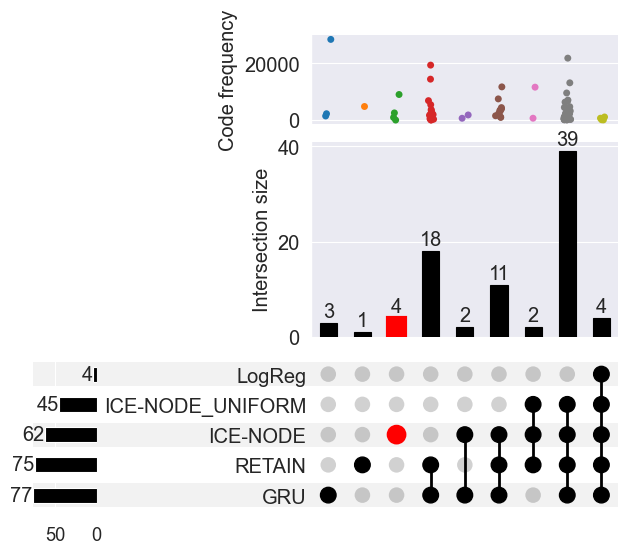

In [35]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',)
#                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')
m4_code_attrs = {'Code frequency': m4_interface.dx_flatccs_frequency(m4_train_ids)}

m4_upset_result = A.relative_performance_upset(auctests_m4, upset_clfs, 
                                               code_attrs=m4_code_attrs,
                                               **relative_auc_config)
upset_ctx = lambda : sns.plotting_context("paper",  font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(m4_upset_result['indicator_df'], data=m4_upset_result['data'])
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(present=['ICE-NODE'], absent=('ICE-NODE_UNIFORM', 'GRU', 'RETAIN'),
                               edgecolor="red", linewidth=3, facecolor="red")
    upset_object.add_catplot(value='Code frequency', kind="strip")

    g = upset_object.plot()
    current_figure = plt.gcf()
#     w, h = 5, 3
#     wi, hi = current_figure.get_size_inches()
#     current_figure.set_size_inches(hi*(w/h), hi)

    current_figure.savefig(f"{output_dir}/upset_M4.pdf", bbox_inches='tight')
    plt.show()


In [36]:
results_m4_eval, _ = A.evaluation_table(test_res_m4, m4_train_percentiles, top_k_list=top_k_list)

In [37]:
table_clfs = ('LogReg', 
              'RETAIN',
              'GRU',
              'GRU/G',
              'ICE-NODE_UNIFORM',
              'ICE-NODE_UNIFORM/G',
              'ICE-NODE', 
              'ICE-NODE/G',
              )
results_m4_tables = A.top_k_tables(table_clfs, results_m4_eval, top_k_list=top_k_list, 
                                   n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M4')

,ACC-P0-k1,ACC-P1-k1,ACC-P2-k1,ACC-P3-k1,ACC-P4-k1
LogReg,0.000,0.016,0.054,0.101,0.239
RETAIN,0.079,0.084,0.078,0.078,0.142
GRU,0.081,0.079,0.083,0.078,0.142
GRU/G,0.077,0.078,0.083,0.082,0.144
ICE-NODE_UNIFORM,0.084,0.077,0.080,0.074,0.148
ICE-NODE_UNIFORM/G,0.075,0.078,0.081,0.078,0.152
ICE-NODE,0.077,0.079,0.081,0.072,0.156
ICE-NODE/G,0.076,0.077,0.082,0.076,0.155


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k1} & {ACC-P1-k1} & {ACC-P2-k1} & {ACC-P3-k1} & {ACC-P4-k1} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.000 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.016 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.054 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.101 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.239 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.079 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.084 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.078 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.078 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.142 \\
\texttt{GRU} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.081 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.079 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.083 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.078 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.142 \\
\textt

,ACC-P0-k2,ACC-P1-k2,ACC-P2-k2,ACC-P3-k2,ACC-P4-k2
LogReg,0.000,0.037,0.104,0.207,0.412
RETAIN,0.124,0.150,0.136,0.156,0.300
GRU,0.123,0.143,0.142,0.161,0.302
GRU/G,0.118,0.141,0.141,0.161,0.306
ICE-NODE_UNIFORM,0.135,0.140,0.130,0.157,0.299
ICE-NODE_UNIFORM/G,0.125,0.139,0.129,0.161,0.306
ICE-NODE,0.129,0.143,0.132,0.154,0.307
ICE-NODE/G,0.126,0.139,0.132,0.157,0.310


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k2} & {ACC-P1-k2} & {ACC-P2-k2} & {ACC-P3-k2} & {ACC-P4-k2} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.000 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.037 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.104 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.207 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.412 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.124 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.150 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.136 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.156 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.300 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.123 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.143 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.142 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.161 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.302 \\
\textt

,ACC-P0-k3,ACC-P1-k3,ACC-P2-k3,ACC-P3-k3,ACC-P4-k3
LogReg,0.000,0.060,0.148,0.306,0.546
RETAIN,0.158,0.205,0.188,0.236,0.442
GRU,0.154,0.199,0.197,0.244,0.439
GRU/G,0.149,0.196,0.197,0.242,0.446
ICE-NODE_UNIFORM,0.168,0.197,0.179,0.234,0.432
ICE-NODE_UNIFORM/G,0.159,0.197,0.176,0.239,0.439
ICE-NODE,0.163,0.201,0.182,0.232,0.439
ICE-NODE/G,0.162,0.197,0.181,0.235,0.444


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k3} & {ACC-P1-k3} & {ACC-P2-k3} & {ACC-P3-k3} & {ACC-P4-k3} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.000 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.060 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.148 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.306 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.546 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.158 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.205 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.188 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.236 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.442 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.154 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.199 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.197 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.244 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.439 \\
\textt

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
LogReg,0.001,0.101,0.239,0.469,0.724
RETAIN,0.217,0.288,0.292,0.378,0.643
GRU,0.208,0.283,0.302,0.387,0.642
GRU/G,0.207,0.281,0.300,0.388,0.649
ICE-NODE_UNIFORM,0.231,0.286,0.277,0.369,0.621
ICE-NODE_UNIFORM/G,0.223,0.289,0.272,0.373,0.624
ICE-NODE,0.227,0.289,0.282,0.367,0.627
ICE-NODE/G,0.225,0.286,0.279,0.370,0.634


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.001 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.101 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.239 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.469 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.724 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.217 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.288 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.292 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.378 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.643 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.208 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.283 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.302 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.387 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.642 \\
\textt

,ACC-P0-k7,ACC-P1-k7,ACC-P2-k7,ACC-P3-k7,ACC-P4-k7
LogReg,0.003,0.145,0.333,0.595,0.813
RETAIN,0.265,0.346,0.383,0.497,0.759
GRU,0.252,0.345,0.393,0.509,0.756
GRU/G,0.253,0.342,0.390,0.509,0.764
ICE-NODE_UNIFORM,0.279,0.350,0.365,0.477,0.735
ICE-NODE_UNIFORM/G,0.271,0.351,0.361,0.481,0.735
ICE-NODE,0.277,0.355,0.371,0.477,0.739
ICE-NODE/G,0.276,0.352,0.368,0.480,0.745


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k7} & {ACC-P1-k7} & {ACC-P2-k7} & {ACC-P3-k7} & {ACC-P4-k7} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.003 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.145 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.333 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.595 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.813 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.265 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.346 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.383 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.497 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.759 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.252 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.345 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.393 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.509 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.756 \\
\textt

,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
LogReg,0.008,0.223,0.444,0.737,0.882
RETAIN,0.312,0.409,0.491,0.640,0.856
GRU,0.300,0.411,0.500,0.652,0.849
GRU/G,0.303,0.410,0.497,0.651,0.857
ICE-NODE_UNIFORM,0.328,0.417,0.471,0.612,0.828
ICE-NODE_UNIFORM/G,0.321,0.416,0.467,0.616,0.828
ICE-NODE,0.327,0.421,0.478,0.615,0.832
ICE-NODE/G,0.326,0.421,0.474,0.614,0.835


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.008 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.223 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.444 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.737 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.882 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.312 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.409 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.491 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.640 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.856 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.300 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.411 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.500 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.652 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.849 \\
\

,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
LogReg,0.019,0.347,0.606,0.869,0.943
RETAIN,0.362,0.483,0.621,0.806,0.928
GRU,0.355,0.491,0.633,0.808,0.917
GRU/G,0.357,0.491,0.628,0.809,0.921
ICE-NODE_UNIFORM,0.376,0.486,0.598,0.773,0.904
ICE-NODE_UNIFORM/G,0.370,0.485,0.593,0.779,0.903
ICE-NODE,0.375,0.493,0.605,0.774,0.904
ICE-NODE/G,0.374,0.491,0.601,0.776,0.906


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.019 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.347 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.606 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.869 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.943 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.362 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.483 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.621 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.806 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.928 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.355 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.491 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.633 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.808 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.917 \\
\

,ACC-P0-k20,ACC-P1-k20,ACC-P2-k20,ACC-P3-k20,ACC-P4-k20
LogReg,0.035,0.451,0.740,0.926,0.971
RETAIN,0.398,0.544,0.725,0.898,0.963
GRU,0.396,0.558,0.733,0.896,0.950
GRU/G,0.399,0.558,0.725,0.898,0.953
ICE-NODE_UNIFORM,0.405,0.540,0.694,0.870,0.944
ICE-NODE_UNIFORM/G,0.401,0.540,0.692,0.874,0.944
ICE-NODE,0.406,0.548,0.704,0.869,0.942
ICE-NODE/G,0.406,0.546,0.700,0.872,0.944


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k20} & {ACC-P1-k20} & {ACC-P2-k20} & {ACC-P3-k20} & {ACC-P4-k20} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.035 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.451 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.740 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.926 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.971 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.398 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.544 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.725 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.898 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.963 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.396 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.558 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.733 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.896 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.950 \\
\

In [38]:
icenode_m4_excl = m4_upset_result['content_sets']['ICE-NODE'] - set.union(*list(m4_upset_result['content_sets'][clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4_excl = m4_upset_result['competing_performance'][m4_upset_result['competing_performance']['CODE_INDEX'].isin(icenode_m4_excl)]
icenode_m4_excl

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(GRU/G),AUC(ICE-NODE),AUC(ICE-NODE/G),AUC(ICE-NODE_UNIFORM),AUC(ICE-NODE_UNIFORM/G),AUC(LogReg),AUC(RETAIN),...,P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE/G==AUC_LogReg),P0(AUC_ICE-NODE/G==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE_UNIFORM==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM/G==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN),P0(AUC_LogReg==AUC_RETAIN),DESC
6,6,2063.0,0.899,0.901,0.917,0.915,0.892,0.892,0.892,0.899,...,5.134e-24,9.131e-15,2.729e-09,0.794,9.974e-01,8.068e-05,9.344e-01,9.193e-05,7.969e-05,Pulm hart dx
94,94,129.0,0.959,0.960,0.969,0.971,0.960,0.959,0.926,0.961,...,7.252e-05,8.035e-11,2.701e-03,0.446,2.419e-07,4.685e-01,4.620e-07,2.815e-01,3.944e-09,Early labor
105,105,1040.0,0.981,0.981,0.984,0.985,0.979,0.979,0.970,0.980,...,2.064e-12,1.412e-25,9.216e-11,0.370,3.887e-09,2.257e-01,4.003e-10,3.306e-01,1.512e-15,Forceps del
236,236,8394.0,0.888,0.881,0.912,0.913,0.886,0.885,0.870,0.890,...,1.172e-92,3.731e-99,2.282e-45,0.026,1.358e-17,1.826e-03,4.539e-16,1.793e-04,3.536e-36,Other ear dx


In [39]:
# icenode_ratain_gru_m4 = upsetcontents_m4['ICE-NODE']
# icenode_ratain_gru_m4 = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_ratain_gru_m4)]
# icenode_ratain_gru_m4.sort_values('AUC(ICE-NODE)', ascending=False)[['CODE_INDEX', 'N_POSITIVE_CODES', 'DESC', 'AUC(ICE-NODE)']]

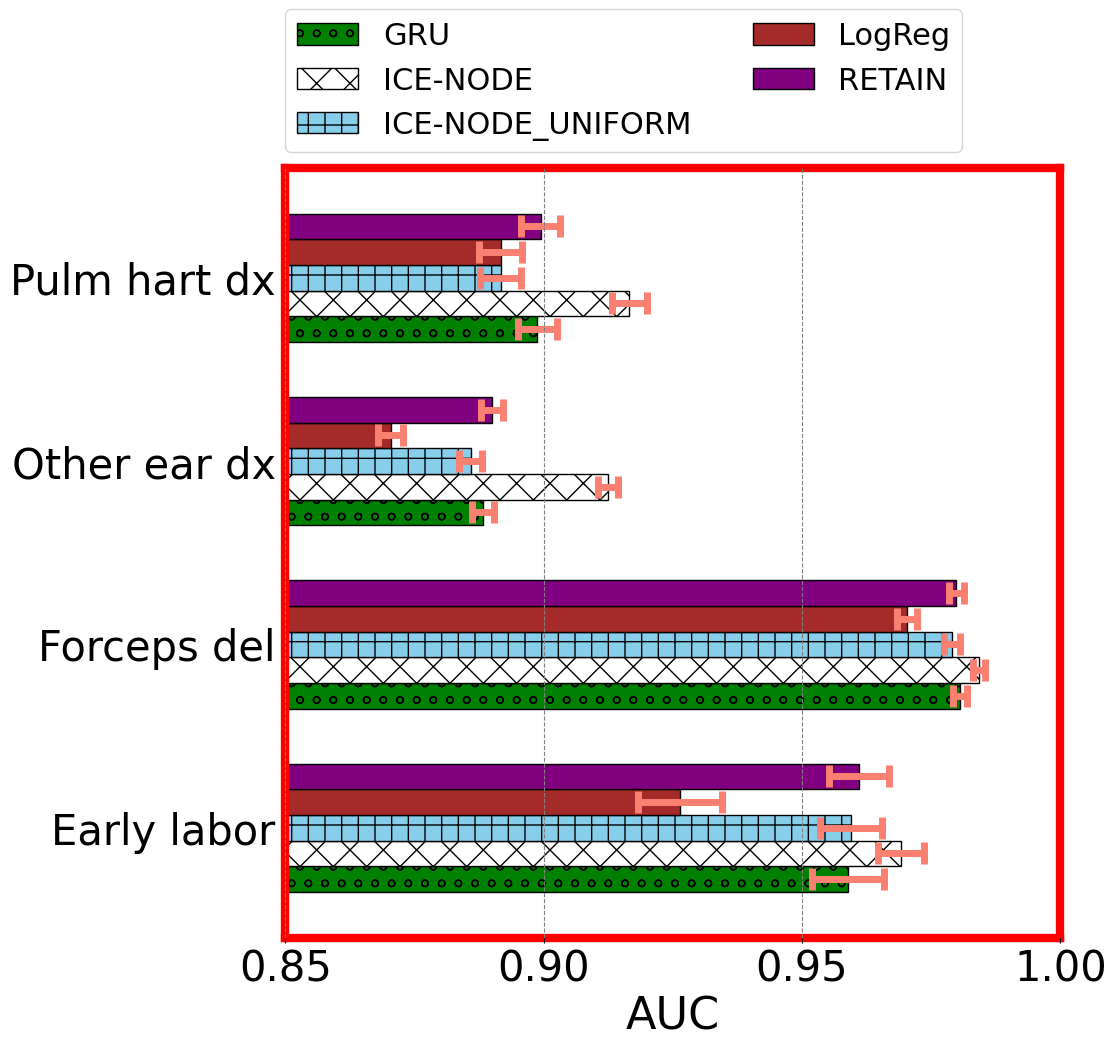

In [40]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg')
w, h = 4, 3
ax = A.selected_auc_barplot(upset_clfs, icenode_m4_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
current_figure = plt.gcf()
w, h = 4, 4
wi, hi = current_figure.get_size_inches()
current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig(f"{output_dir}/icenode_m4.pdf", bbox_inches='tight')
plt.show()


<a name="sec4"></a>

## 4 Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All) [^](#outline)

In [ ]:
# clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m3_subjects = list(m3_interface_M.subjects.keys())
m4m3_predictors = {clf: cross_predictor(clf, 'M4', 'M3') for clf in clfs}

In [ ]:
test_res_m4m3 = {clf: C.eval2_(model, m3_subjects) for clf, model in m4m3_predictors.items()} 

In [ ]:
auctests_m4m3 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m4m3.items()}, fast=True)

53 codes predicted an AUC higher than 0.9 by at least one model.
50 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


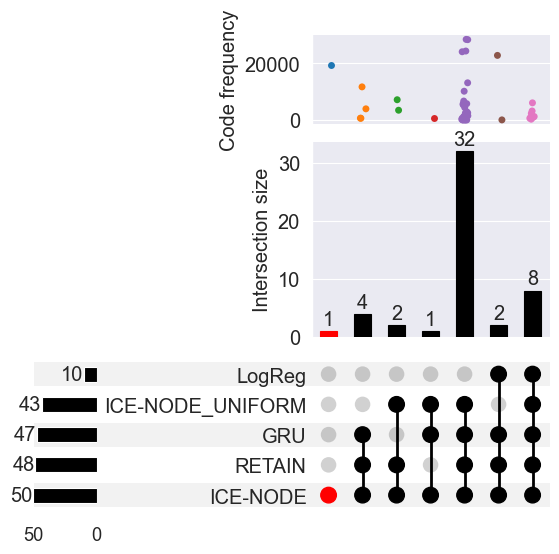

In [44]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',)
#                 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

m4m3_code_attrs = {'Code frequency': m4_interface.dx_flatccs_frequency(m4_train_ids)}

m4m3_upset_result = A.relative_performance_upset(auctests_m4m3, upset_clfs, 
                                                 code_attrs=m4m3_code_attrs,
                                                 **relative_auc_config)

upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(m4m3_upset_result['indicator_df'], data=m4m3_upset_result['data'])
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.add_catplot(value='Code frequency', kind="strip")

    upset_object.style_subsets(present='ICE-NODE', absent=['ICE-NODE_UNIFORM', 'GRU', 'RETAIN'],
                              edgecolor="red", facecolor="red")
    g = upset_object.plot()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/upset_M4M3.pdf", bbox_inches='tight')
    plt.show()

In [45]:
results_m4m3_eval, _ = A.evaluation_table(test_res_m4m3, m4_train_percentiles, top_k_list=top_k_list)

In [46]:
table_clfs = ('LogReg', 
              'RETAIN',
              'GRU',
              'GRU/G',
              'ICE-NODE', 
              'ICE-NODE/G',
              'ICE-NODE_UNIFORM',
              'ICE-NODE_UNIFORM/G'
              )

results_m4m3_tables = A.top_k_tables(table_clfs, results_m4m3_eval, top_k_list=top_k_list, 
                                     n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M4M3')

,ACC-P0-k1,ACC-P1-k1,ACC-P2-k1,ACC-P3-k1,ACC-P4-k1
LogReg,0.000,0.005,0.038,0.105,0.236
RETAIN,0.076,0.054,0.080,0.077,0.141
GRU,0.079,0.052,0.076,0.077,0.151
GRU/G,0.075,0.049,0.078,0.084,0.143
ICE-NODE,0.069,0.044,0.082,0.082,0.161
ICE-NODE/G,0.068,0.043,0.083,0.086,0.154
ICE-NODE_UNIFORM,0.072,0.044,0.079,0.085,0.155
ICE-NODE_UNIFORM/G,0.065,0.045,0.080,0.089,0.156


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k1} & {ACC-P1-k1} & {ACC-P2-k1} & {ACC-P3-k1} & {ACC-P4-k1} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.000 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.005 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.038 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.105 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.236 \\
\texttt{RETAIN} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.076 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.054 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.080 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.077 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.141 \\
\texttt{GRU} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.079 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.052 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.076 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.077 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.151 \\
\textt

,ACC-P0-k2,ACC-P1-k2,ACC-P2-k2,ACC-P3-k2,ACC-P4-k2
LogReg,0.000,0.015,0.075,0.218,0.415
RETAIN,0.119,0.103,0.140,0.161,0.283
GRU,0.117,0.095,0.145,0.167,0.292
GRU/G,0.114,0.095,0.139,0.171,0.296
ICE-NODE,0.117,0.092,0.136,0.174,0.292
ICE-NODE/G,0.118,0.091,0.136,0.175,0.291
ICE-NODE_UNIFORM,0.123,0.092,0.135,0.177,0.282
ICE-NODE_UNIFORM/G,0.115,0.093,0.129,0.180,0.291


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k2} & {ACC-P1-k2} & {ACC-P2-k2} & {ACC-P3-k2} & {ACC-P4-k2} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.000 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.015 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.075 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.218 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.415 \\
\texttt{RETAIN} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.119 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.103 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.140 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.161 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.283 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.117 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.095 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.145 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.167 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.292 \\
\textt

,ACC-P0-k3,ACC-P1-k3,ACC-P2-k3,ACC-P3-k3,ACC-P4-k3
LogReg,0.001,0.028,0.110,0.322,0.552
RETAIN,0.155,0.143,0.194,0.249,0.406
GRU,0.149,0.135,0.194,0.257,0.426
GRU/G,0.146,0.134,0.195,0.259,0.423
ICE-NODE,0.154,0.134,0.187,0.254,0.413
ICE-NODE/G,0.152,0.131,0.186,0.256,0.419
ICE-NODE_UNIFORM,0.159,0.132,0.186,0.258,0.407
ICE-NODE_UNIFORM/G,0.149,0.135,0.176,0.264,0.415


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k3} & {ACC-P1-k3} & {ACC-P2-k3} & {ACC-P3-k3} & {ACC-P4-k3} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.001 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.028 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.110 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.322 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.552 \\
\texttt{RETAIN} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.155 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.143 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.194 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.249 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.406 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.149 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.135 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.194 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.257 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.426 \\
\textt

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
LogReg,0.003,0.061,0.193,0.481,0.718
RETAIN,0.214,0.210,0.291,0.395,0.593
GRU,0.200,0.199,0.296,0.405,0.609
GRU/G,0.197,0.198,0.292,0.408,0.608
ICE-NODE,0.216,0.203,0.275,0.391,0.596
ICE-NODE/G,0.214,0.202,0.275,0.390,0.601
ICE-NODE_UNIFORM,0.221,0.204,0.273,0.393,0.593
ICE-NODE_UNIFORM/G,0.210,0.206,0.268,0.398,0.598


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.003 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.061 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.193 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.481 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.718 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.214 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.210 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.291 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.395 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.593 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.200 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.199 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.296 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.405 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.609 \\
\textt

,ACC-P0-k7,ACC-P1-k7,ACC-P2-k7,ACC-P3-k7,ACC-P4-k7
LogReg,0.007,0.095,0.285,0.601,0.799
RETAIN,0.257,0.259,0.373,0.510,0.712
GRU,0.240,0.249,0.373,0.526,0.721
GRU/G,0.241,0.249,0.368,0.522,0.726
ICE-NODE,0.264,0.259,0.354,0.494,0.716
ICE-NODE/G,0.263,0.256,0.354,0.494,0.719
ICE-NODE_UNIFORM,0.267,0.258,0.351,0.500,0.712
ICE-NODE_UNIFORM/G,0.258,0.258,0.347,0.503,0.713


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k7} & {ACC-P1-k7} & {ACC-P2-k7} & {ACC-P3-k7} & {ACC-P4-k7} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.007 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.095 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.285 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.601 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.799 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.257 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.259 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.373 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.510 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.712 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.240 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.249 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.373 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.526 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.721 \\
\textt

,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
LogReg,0.014,0.152,0.384,0.744,0.866
RETAIN,0.301,0.314,0.474,0.647,0.820
GRU,0.282,0.310,0.475,0.672,0.818
GRU/G,0.286,0.309,0.470,0.664,0.825
ICE-NODE,0.311,0.316,0.459,0.627,0.811
ICE-NODE/G,0.311,0.317,0.455,0.625,0.817
ICE-NODE_UNIFORM,0.316,0.320,0.453,0.626,0.807
ICE-NODE_UNIFORM/G,0.306,0.316,0.451,0.632,0.811


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.014 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.152 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.384 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.744 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.866 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.301 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.314 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.474 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.647 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.820 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.282 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.310 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.475 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.672 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.818 \\
\

,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
LogReg,0.027,0.240,0.543,0.858,0.939
RETAIN,0.351,0.385,0.602,0.805,0.905
GRU,0.332,0.392,0.610,0.819,0.896
GRU/G,0.335,0.392,0.604,0.820,0.900
ICE-NODE,0.361,0.389,0.584,0.780,0.894
ICE-NODE/G,0.360,0.386,0.584,0.780,0.896
ICE-NODE_UNIFORM,0.363,0.391,0.581,0.779,0.890
ICE-NODE_UNIFORM/G,0.357,0.385,0.578,0.786,0.892


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.027 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.240 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.543 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.858 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.939 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.351 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.385 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.602 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.805 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.905 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.332 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.392 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.610 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.819 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.896 \\
\

,ACC-P0-k20,ACC-P1-k20,ACC-P2-k20,ACC-P3-k20,ACC-P4-k20
LogReg,0.042,0.317,0.701,0.910,0.971
RETAIN,0.383,0.449,0.706,0.886,0.947
GRU,0.374,0.461,0.722,0.892,0.935
GRU/G,0.375,0.462,0.711,0.897,0.939
ICE-NODE,0.392,0.450,0.687,0.870,0.938
ICE-NODE/G,0.392,0.444,0.683,0.872,0.939
ICE-NODE_UNIFORM,0.393,0.449,0.683,0.870,0.939
ICE-NODE_UNIFORM/G,0.389,0.443,0.681,0.875,0.940


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k20} & {ACC-P1-k20} & {ACC-P2-k20} & {ACC-P3-k20} & {ACC-P4-k20} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.042 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.317 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.701 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.910 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.971 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.383 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.449 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.706 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.886 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.947 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.374 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.461 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.722 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.892 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.935 \\
\

In [47]:
icenode_m4m3_excl = m4m3_upset_result['content_sets']['ICE-NODE'] - set.union(*list(m4m3_upset_result['content_sets'][clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4m3_excl = compete_codesm4m3[m4m3_upset_result['competing_performance']['CODE_INDEX'].isin(icenode_m4m3_excl)]
icenode_m4m3_excl

NameError: name 'compete_codesm4m3' is not defined

In [ ]:
ax = A.selected_auc_barplot(upset_clfs, icenode_m4m3_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.legend(fontsize=22, title_fontsize=32,
#           bbox_to_anchor=(0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(1, 1.25), ncol=2)

current_figure = plt.gcf()
current_figure.savefig(f"{output_dir}/icenode_m4m3.pdf", bbox_inches='tight')
plt.show()


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [34]:
def admissions_auc_scores(model, test_ids):
    model, state = model
    return model.admissions_auc_scores(state, test_ids)

In [35]:
m4_icenode_visit_auc_df = admissions_auc_scores(m4_predictors['ICE-NODE'], m4_test_ids)
m4_icenode_visit_auc_df['N_VISITS'] = m4_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())

In [36]:
m4_visit_auc_subject = m4_icenode_visit_auc_df.groupby('SUBJECT_ID').agg(
    {'AUC': 'mean', 
     'N_VISITS': 'max', 
     'N_CODES': ['min', 'max', 'mean', 'median'], 
     'INTERVALS': ['mean', 'max', 'min'] })

In [37]:
m4m3_icenode_visit_auc_df = admissions_auc_scores(m4m3_predictors['ICE-NODE'], m3_interface.subjects.keys())
m4m3_icenode_visit_auc_df['N_VISITS'] = m4m3_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4m3_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
m4m3_visit_auc_subject = m4m3_icenode_visit_auc_df.groupby('SUBJECT_ID').agg(
    {'AUC': 'mean', 
     'N_VISITS': 'max', 
     'N_CODES': ['min', 'max', 'mean', 'median'], 
     'INTERVALS': ['mean', 'max', 'min']
    })


In [38]:
m4_best_visit_auc_subjects =  m4_visit_auc_subject[(m4_visit_auc_subject.N_VISITS['max'] > 2) & (m4_visit_auc_subject.INTERVALS['max'] < 150)]
m4m3_best_visit_auc_subjects =  m4m3_visit_auc_subject[(m4m3_visit_auc_subject.N_VISITS['max'] > 1) & (m4m3_visit_auc_subject.INTERVALS['max'] < 150)]


In [39]:
len(m4_best_visit_auc_subjects), len(m4m3_best_visit_auc_subjects)

(365, 220)

In [40]:
m4_ccs_history = {i: m4_interface.dx_flatccs_history(i) for i in m4_best_visit_auc_subjects.index}
m4m3_ccs_history = {i: m3_interface.dx_flatccs_history(i) for i in m4m3_best_visit_auc_subjects.index}

m4_ccs_idx_frequency = m4_interface.dx_flatccs_frequency(list(m4_best_visit_auc_subjects.index))
m3_ccs_idx_frequency = m3_interface.dx_flatccs_frequency(list(m4m3_best_visit_auc_subjects.index))

In [41]:
m4_history_all_ccs_codes = set(map(C.ccs_dag.dx_flatccs_idx.get, set.union(*[set(h.keys()) for h in m4_ccs_history.values()])))
m3_history_all_ccs_codes = set(map(C.ccs_dag.dx_flatccs_idx.get, set.union(*[set(h.keys()) for h in m4m3_ccs_history.values()])))
m4_history_all_ccs_codes = {idx for idx in m4_history_all_ccs_codes if m4_ccs_idx_frequency[idx] < 10}
m3_history_all_ccs_codes = {idx for idx in m3_history_all_ccs_codes if m3_ccs_idx_frequency[idx] < 10}

len(m4_history_all_ccs_codes), len(m3_history_all_ccs_codes)

(51, 74)

In [42]:
icenode_m4_competent = upsetcontents_m4['ICE-NODE'] 
icenode_m4_competent = auctests_m4[auctests_m4['CODE_INDEX'].isin(icenode_m4_competent)]
icenode_m4_competent = icenode_m4_competent[['N_POSITIVE_CODES', 'AUC(ICE-NODE)', 'DESC']].sort_values('N_POSITIVE_CODES',ascending=False)
# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]
icenode_m4_competent[icenode_m4_competent.index.isin(trajectory_ccs_codes_level2)]

,N_POSITIVE_CODES,AUC(ICE-NODE),DESC
173,1790.0,0.941892,Non-Hodg lym
168,520.0,0.951321,Kidny/rnl ca
216,244.0,0.974325,Meningitis
169,181.0,0.942847,Uriny org ca
156,148.0,0.965231,Uterus cancr
165,146.0,0.957154,Testis cancr
171,89.0,0.940833,Thyroid cncr
100,84.0,0.952710,Brnch/lng ca
167,67.0,0.957488,Bladder cncr


In [43]:
trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
]


In [44]:
m4_ccs_history_level1 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}
m4m3_ccs_history_level1 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}

m4_ccs_history_level2 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}
m4m3_ccs_history_level2 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}

In [45]:
len(m4_ccs_history_level1), len(m4m3_ccs_history_level1), len(m4_ccs_history_level2), len(m4m3_ccs_history_level2) 


(180, 115, 68, 35)

In [46]:
m4_cases = set(m4_ccs_history_level1.keys()) | set(m4_ccs_history_level2.keys())
m4m3_cases = set(m4m3_ccs_history_level1.keys()) | set(m4m3_ccs_history_level2.keys())
len(m4_cases), len(m4m3_cases)

(206, 131)

In [47]:
m4_icenode, m4_icenode_state = m4_predictors['ICE-NODE']
m4_trajectory = m4_icenode.sample_trajectory(m4_icenode_state, m4_cases, 1)

  0%|                                                    | 0/22 [00:00<?, ?it/s]/home/asem/GP/ICENODE/notebooks/../icenode/ehr_predictive/dx_icenode_tl.py:412: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
100%|███████████████████████████████████████████| 22/22 [34:49<00:00, 94.97s/it]


In [48]:
m4m3_icenode, m4m3_icenode_state = m4m3_predictors['ICE-NODE']
m4m3_trajectory = m4m3_icenode.sample_trajectory(m4m3_icenode_state, m4m3_cases, 1)

100%|█████████████████████████████████████████████| 9/9 [12:57<00:00, 86.38s/it]


In [49]:
# m4_selected_subjects = [
#     13798593, #acute-renal
#     13965528, #acute-renal
#     11907876, #pulmonary heart dx
#     13557547, #ear dx
#     10139504, #acute renal fail
#     12367864, #pulomonary-heart dx
# ]

# m4_selected_trajectory = {i: m4_trajectory[i] for i in m4_selected_subjects}

# m3_selected_subjects = [
#     50093 #pulmonary-heart dx
# ]

# m3_selected_trajectory = {i: m4m3_trajectory[i] for i in m3_selected_subjects}


In [174]:
import random

trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
    # Others
    100, # Brnch/lng ca
    168, # Kidney/rnl ca
    194, # Immunity dx
]



# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]

random.seed(42)
ccs_color = {
    6: 'blue',
    64: 'purple',
    236: 'orange',
    # Others
    100: 'salmon', # Brnch/lng ca
    168: 'navy', # Kidney/rnl ca
    194: 'pink', # Immunity dx
    **{idx: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                   for idx in trajectory_ccs_codes_level2}
}


plt.rcParams['figure.figsize'] = (10, 7)



In [183]:
plt.close('all')
for data_label, interface, trajectory_set in zip(["M4", "M3"], [m4_interface, m3_interface], [m4_trajectory, m4m3_trajectory]):
    for indices_label, ccs_indices in zip(["L1", "L2", "L1UL2"], [trajectory_ccs_codes_level1, trajectory_ccs_codes_level2, trajectory_ccs_codes_level1 + trajectory_ccs_codes_level2]):
        out_dir = f'{output_dir}/trajectories/{data_label}_{indices_label}' 
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        A.plot_trajectory(trajectories=trajectory_set, 
                          interface=interface, 
                          flatccs_selection=ccs_indices, 
                          ccs_color=ccs_color,
                          out_dir=out_dir)

/home/asem/GP/ICENODE/notebooks/analysis.py:443: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)
